# Week 1 : Systematically Improving Your RAG Application

## Determining Statistical Significance

We want to do some statistical testing to see if there are any significant diffeerences. There are a few different ways to do this, but we'll use a simple approach to start with.

For this, we'll be comparing the embedding models - `text-embedding-3-small` with a re-ranker and `text-embedding-3-large` using vector search.


In [109]:
# Fetch from Braintrust

text_emb_3_small = (
    "7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-small"
)
text_emb_3_large_vector = (
    "7eff5eae-a5a3-4b9c-8e67-e14103dcb5f6-none-vector-text-embedding-3-large"
)

In [110]:
import braintrust


def get_braintrust_results(experiment_id):
    experiment = braintrust.init(
        project="Text-2-SQL",  # Replace with your project name
        experiment=experiment_id,  # Replace with your experiment name
        open=True,
    )

    results = []
    for test in experiment:
        if test["root_span_id"] != test["span_id"]:
            continue
        results.append(test)
    return results


text_emb_3_small_results = get_braintrust_results(text_emb_3_small)
text_emb_3_large_vector_results = get_braintrust_results(text_emb_3_large_vector)

In [111]:
def get_label_and_pred(row):
    labels = [row["metadata"]["chunk_id"]]
    preds = [item["id"] for item in row["output"]]
    return labels, preds


def calculate_mrr(predictions: list[str], gt: list[str]):
    mrr = 0
    for label in gt:
        if label in predictions:
            # Find the relevant item that has the smallest index
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr


def calculate_recall(predictions: list[str], gt: list[str]):
    # Calculate the proportion of relevant items that were retrieved
    return len([label for label in gt if label in predictions]) / len(gt)

In [120]:
import pandas as pd
import numpy as np

metrics = [("recall", calculate_recall), ("mrr", calculate_mrr)]
k = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

In [126]:
def compute_metrics(rows):
    """Compute metrics for a list of rows."""
    scores = []

    for row in rows:
        labels, predictions = get_label_and_pred(row)

        row_scores = {}
        # Calculate each metric at each k value
        for metric_name, metric_fn in metrics:
            for subset_k in k:
                metric_key = f"{metric_name}@{subset_k}"
                row_scores[metric_key] = metric_fn(predictions[:subset_k], labels)

        scores.append(row_scores)

    # Convert to DataFrame and calculate statistics
    return pd.DataFrame(scores).mean()


text_emb_3_small_metrics = compute_metrics(text_emb_3_small_results)
text_emb_3_large_vector_metrics = compute_metrics(text_emb_3_large_vector_results)

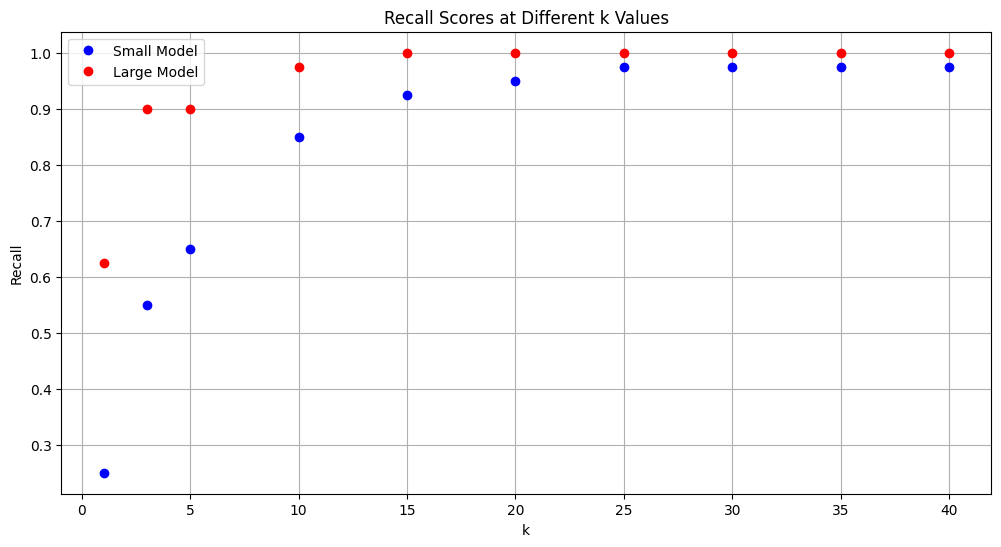

In [129]:
import matplotlib.pyplot as plt

# Create figure with larger size
plt.figure(figsize=(12, 6))

# Get all k values and corresponding recall scores
small_recalls = [text_emb_3_small_metrics[f"recall@{k_val}"] for k_val in k]
large_recalls = [text_emb_3_large_vector_metrics[f"recall@{k_val}"] for k_val in k]

# Plot recall metrics
plt.plot(k, small_recalls, "bo", label="Small Model")  # Blue dots for small model
plt.plot(k, large_recalls, "ro", label="Large Model")  # Red dots for large model

plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Recall Scores at Different k Values")
plt.legend()
plt.grid(True)
plt.show()

In [112]:
def bootstrap_sample(rows):
    import numpy as np

    # Calculate metrics for all rows
    sample = np.random.choice(rows, size=len(rows), replace=True)
    sample_scores = []

    for row in sample:
        labels, predictions = get_label_and_pred(row)

        row_scores = {}
        # Calculate each metric at each k value
        for metric_name, metric_fn in metrics:
            for subset_k in k:
                metric_key = f"{metric_name}@{subset_k}"
                row_scores[metric_key] = metric_fn(predictions[:subset_k], labels)

        sample_scores.append(row_scores)

    # Convert to DataFrame and calculate statistics
    df = pd.DataFrame(sample_scores)

    return {"means": df.mean().to_dict(), "stds": df.std().to_dict()}

In [113]:
N_SAMPLES = 5000

# Bootstrap for emb_reranker_results
text_emb_3_small_bootstrap_means = []
text_emb_3_small_bootstrap_sds = []

for _ in range(N_SAMPLES):
    bootstrap_results = bootstrap_sample(text_emb_3_small_results)
    text_emb_3_small_bootstrap_means.append(bootstrap_results["means"])
    text_emb_3_small_bootstrap_sds.append(bootstrap_results["stds"])

text_emb_3_small_bootstrap_means = pd.DataFrame(text_emb_3_small_bootstrap_means)
text_emb_3_small_bootstrap_sds = pd.DataFrame(text_emb_3_small_bootstrap_sds)

# Bootstrap for emb_vector_results
text_emb_3_large_vector_bootstrap_means = []
text_emb_3_large_vector_bootstrap_sds = []

for _ in range(N_SAMPLES):
    bootstrap_results = bootstrap_sample(text_emb_3_large_vector_results)
    text_emb_3_large_vector_bootstrap_means.append(bootstrap_results["means"])
    text_emb_3_large_vector_bootstrap_sds.append(bootstrap_results["stds"])

text_emb_3_large_vector_bootstrap_means = pd.DataFrame(
    text_emb_3_large_vector_bootstrap_means
)
text_emb_3_large_vector_bootstrap_sds = pd.DataFrame(
    text_emb_3_large_vector_bootstrap_sds
)

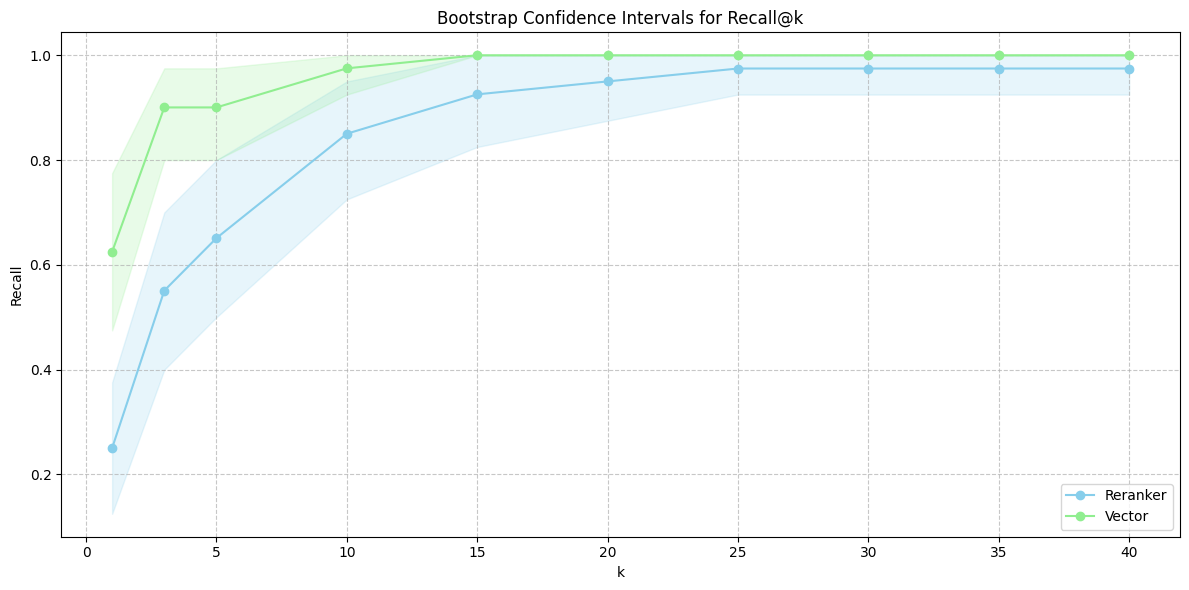

In [114]:
import matplotlib.pyplot as plt

# Get all recall@k columns
recall_cols = [
    col for col in text_emb_3_small_bootstrap_means.columns if col.startswith("recall@")
]

# Extract k values and sort them
k_values = sorted([int(col.split("@")[1]) for col in recall_cols])

# Calculate means and confidence intervals for both methods
text_emb_3_small_means = [
    text_emb_3_small_bootstrap_means[f"recall@{k}"].mean() for k in k_values
]
text_emb_3_large_vector_means = [
    text_emb_3_large_vector_bootstrap_means[f"recall@{k}"].mean() for k in k_values
]

# Calculate confidence intervals
text_emb_3_small_ci_lower = [
    np.percentile(text_emb_3_small_bootstrap_means[f"recall@{k}"], 2.5)
    for k in k_values
]
text_emb_3_small_ci_upper = [
    np.percentile(text_emb_3_small_bootstrap_means[f"recall@{k}"], 97.5)
    for k in k_values
]
text_emb_3_large_vector_ci_lower = [
    np.percentile(text_emb_3_large_vector_bootstrap_means[f"recall@{k}"], 2.5)
    for k in k_values
]
text_emb_3_large_vector_ci_upper = [
    np.percentile(text_emb_3_large_vector_bootstrap_means[f"recall@{k}"], 97.5)
    for k in k_values
]

# Plotting
plt.figure(figsize=(12, 6))

# Plot both methods with confidence intervals
plt.plot(k_values, text_emb_3_small_means, "-o", label="Reranker", color="skyblue")
plt.fill_between(
    k_values,
    text_emb_3_small_ci_lower,
    text_emb_3_small_ci_upper,
    color="skyblue",
    alpha=0.2,
)

plt.plot(
    k_values, text_emb_3_large_vector_means, "-o", label="Vector", color="lightgreen"
)
plt.fill_between(
    k_values,
    text_emb_3_large_vector_ci_lower,
    text_emb_3_large_vector_ci_upper,
    color="lightgreen",
    alpha=0.2,
)

plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Bootstrap Confidence Intervals for Recall@k")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

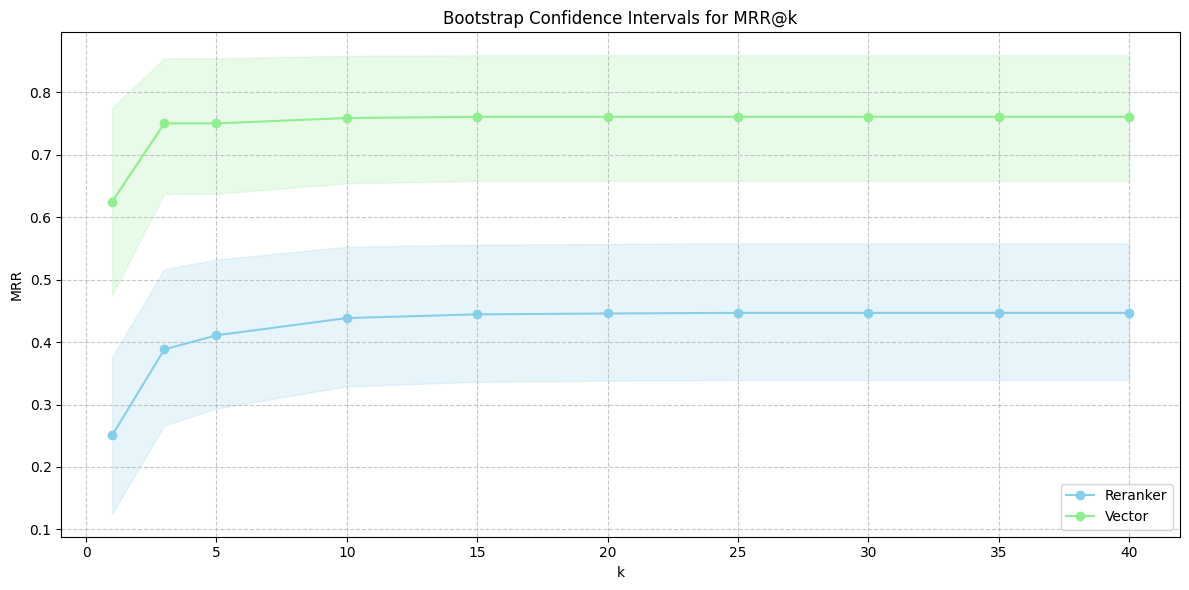

In [117]:
import matplotlib.pyplot as plt

# Get all mrr@k columns
mrr_cols = [
    col for col in text_emb_3_small_bootstrap_means.columns if col.startswith("mrr@")
]

# Extract k values and sort them
k_values = sorted([int(col.split("@")[1]) for col in mrr_cols])

# Calculate means and confidence intervals for both methods
text_emb_3_small_means = [
    text_emb_3_small_bootstrap_means[f"mrr@{k}"].mean() for k in k_values
]
text_emb_3_large_vector_means = [
    text_emb_3_large_vector_bootstrap_means[f"mrr@{k}"].mean() for k in k_values
]

# Calculate confidence intervals
text_emb_3_small_ci_lower = [
    np.percentile(text_emb_3_small_bootstrap_means[f"mrr@{k}"], 2.5) for k in k_values
]
text_emb_3_small_ci_upper = [
    np.percentile(text_emb_3_small_bootstrap_means[f"mrr@{k}"], 97.5) for k in k_values
]
text_emb_3_large_vector_ci_lower = [
    np.percentile(text_emb_3_large_vector_bootstrap_means[f"mrr@{k}"], 2.5)
    for k in k_values
]
text_emb_3_large_vector_ci_upper = [
    np.percentile(text_emb_3_large_vector_bootstrap_means[f"mrr@{k}"], 97.5)
    for k in k_values
]

# Plotting
plt.figure(figsize=(12, 6))

# Plot both methods with confidence intervals
plt.plot(k_values, text_emb_3_small_means, "-o", label="Reranker", color="skyblue")
plt.fill_between(
    k_values,
    text_emb_3_small_ci_lower,
    text_emb_3_small_ci_upper,
    color="skyblue",
    alpha=0.2,
)

plt.plot(
    k_values, text_emb_3_large_vector_means, "-o", label="Vector", color="lightgreen"
)
plt.fill_between(
    k_values,
    text_emb_3_large_vector_ci_lower,
    text_emb_3_large_vector_ci_upper,
    color="lightgreen",
    alpha=0.2,
)

plt.xlabel("k")
plt.ylabel("MRR")
plt.title("Bootstrap Confidence Intervals for MRR@k")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## T-Test

In [118]:
from scipy.stats import ttest_rel

# Get all mrr@k columns
mrr_cols = [
    col for col in text_emb_3_small_bootstrap_means.columns if col.startswith("mrr@")
]

# Extract k values and sort them
k_values = sorted([int(col.split("@")[1]) for col in mrr_cols])

# Perform t-test for each k value
# Create lists to store results
results = []
for k in k_values:
    col = f"mrr@{k}"
    t_stat, p_val = ttest_rel(
        text_emb_3_small_bootstrap_means[col],
        text_emb_3_large_vector_bootstrap_means[col],
    )
    results.append({"k": k, "t_statistic": f"{t_stat:.4f}", "p_value": f"{p_val:.4e}"})

# Create and display dataframe
pd.DataFrame(results).set_index("k")

,t_statistic,p_value
k,,
1,-257.9202,0.0000e+00
3,-299.9854,0.0000e+00
5,-288.1235,0.0000e+00
10,-290.3341,0.0000e+00
15,-290.9472,0.0000e+00
20,-290.4127,0.0000e+00
25,-290.0556,0.0000e+00
30,-290.0556,0.0000e+00
35,-290.0556,0.0000e+00
